<h2>Face Recognition menggunakan Deep Learning Convolutional Neural Network</h2>


projek ini tentang pengenalan gambar, apakah dari gambar tersebut masuk dalam kategori laki-laki, atau masuk dalam kategori perempuan.
data yang saya gunakan berasal dari kaggle dengan data mentah berupa 970 data gambar wajah laki-laki dan 970 data wajah perempuan. dari data tersebut dibagi menjadi dua sebagai data training dan data testing dengan banyaknya data testing 10% dari total data
selain itu, untuk mengecek kevalidan prediksi menggunakan data berupa file campuran antara data gambar wajah, dengan banyaknya data untuk tes kevalidan yaitu 340 data gambar wajah.

In [1]:
# Import Library yang digunakan
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau



%matplotlib inline

Using TensorFlow backend.


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH,IMAGE_HEIGHT)
# channel refer to number of colors, here RGB
IMAGE_CHANNELS=3

In [5]:
# import data berupa file dari folder

data = os.listdir("../train")

In [6]:
# klasifikasi data image

man = (i for i in data if i.split(' ')[0]=='man')
woman = (i for i in data if i.split(' ')[0]=='woman')

df_man = pd.DataFrame({'filename':man,'gender':1})
df_woman = pd.DataFrame({'filename':woman,'gender':0})

In [7]:
df_man.head()

,filename,gender
0,man (1).jpg,1
1,man (10).jpg,1
2,man (100).jpg,1
3,man (101).jpg,1
4,man (102).jpg,1


In [8]:
df_woman.head()

,filename,gender
0,woman (1).jpg,0
1,woman (10).jpg,0
2,woman (100).jpg,0
3,woman (101).jpg,0
4,woman (102).jpg,0


In [9]:
# Penggabungan dari kedua data 

df= pd.concat([df_man,df_woman]).drop_duplicates().reset_index(drop=True)

In [10]:
df

,filename,gender
0,man (1).jpg,1
1,man (10).jpg,1
2,man (100).jpg,1
3,man (101).jpg,1
4,man (102).jpg,1
...,...,...
1933,woman (969).jpg,0
1934,woman (97).jpg,0
1935,woman (970).jpg,0
1936,woman (98).jpg,0


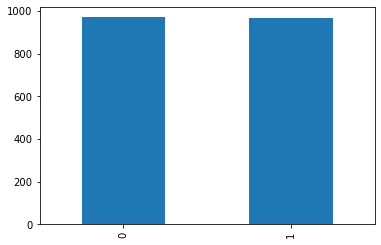

In [11]:
juml = df['gender'].value_counts().plot.bar()

In [12]:
model=Sequential()

# layer Pertama
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer Kedua
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer Ketiga
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Meratakan matriks menjadi matriks tunggal
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Compile model
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [14]:
# Penggunaan Early stop
earlystop = EarlyStopping(patience = 10)
 
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)

callbacks = [earlystop,learning_rate_reduction]

In [15]:
# Mengganti Kategori dengan nama
df["gender"] = df["gender"].replace({1:'Laki-laki',0:'Perempuan'})

# membagi data train dan test
train_df,validate_df = train_test_split(df,test_size=0.10,random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]

batch_size=15

In [17]:
# Preprosessing Training

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../train", 
    x_col='filename',
    y_col='gender',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1744 validated image filenames belonging to 2 classes.


In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../train", 
    x_col='filename',
    y_col='gender',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 194 validated image filenames belonging to 2 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../train", 
    x_col='filename',
    y_col='gender',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


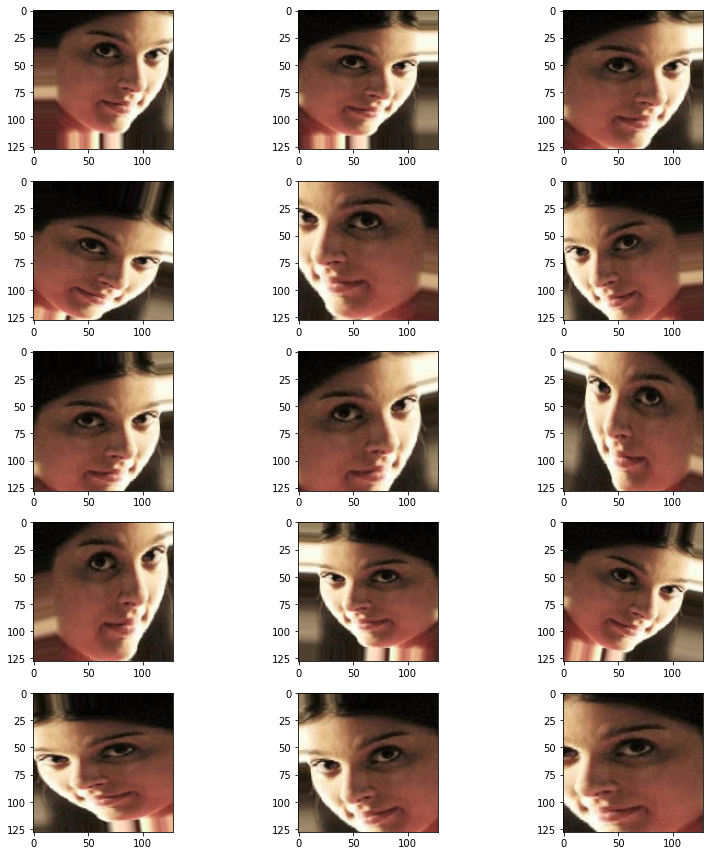

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [22]:
nb_epoch = 5
nb_train_samples = 1744
nb_validation_samples = 194

In [23]:
# Training dataframe

model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

c:\users\owi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
c:\users\owi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=116, epochs=5, validation_steps=194)`
  


Epoch 1/5
116/116 [==============================] - 303s 3s/step - loss: 0.8990 - accuracy: 0.7027 - val_loss: 1.9811 - val_accuracy: 0.5259
Epoch 2/5
116/116 [==============================] - 281s 2s/step - loss: 0.6144 - accuracy: 0.7646 - val_loss: 0.3409 - val_accuracy: 0.7119
Epoch 3/5
116/116 [==============================] - 274s 2s/step - loss: 0.5296 - accuracy: 0.7966 - val_loss: 0.3629 - val_accuracy: 0.8356
Epoch 4/5
116/116 [==============================] - 273s 2s/step - loss: 0.4101 - accuracy: 0.8370 - val_loss: 0.3566 - val_accuracy: 0.7472
Epoch 5/5
116/116 [==============================] - 284s 2s/step - loss: 0.3996 - accuracy: 0.8276 - val_loss: 0.6254 - val_accuracy: 0.8035


In [25]:
# Save Model untuk dilanjutkan ke produksi
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

model.save_weights("model10epoch.h5")

In [27]:
# Test kevalidan prediksi

test_file = os.listdir("../valid")
test_df = pd.DataFrame({
    'filename': test_file
})
nb_samples = test_df.shape[0]

In [28]:
# Preprocessing
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../valid", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=15,
    shuffle=False
)

Found 340 validated image filenames.


In [29]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [30]:
test_df['gender'] = np.argmax(predict, axis=-1)

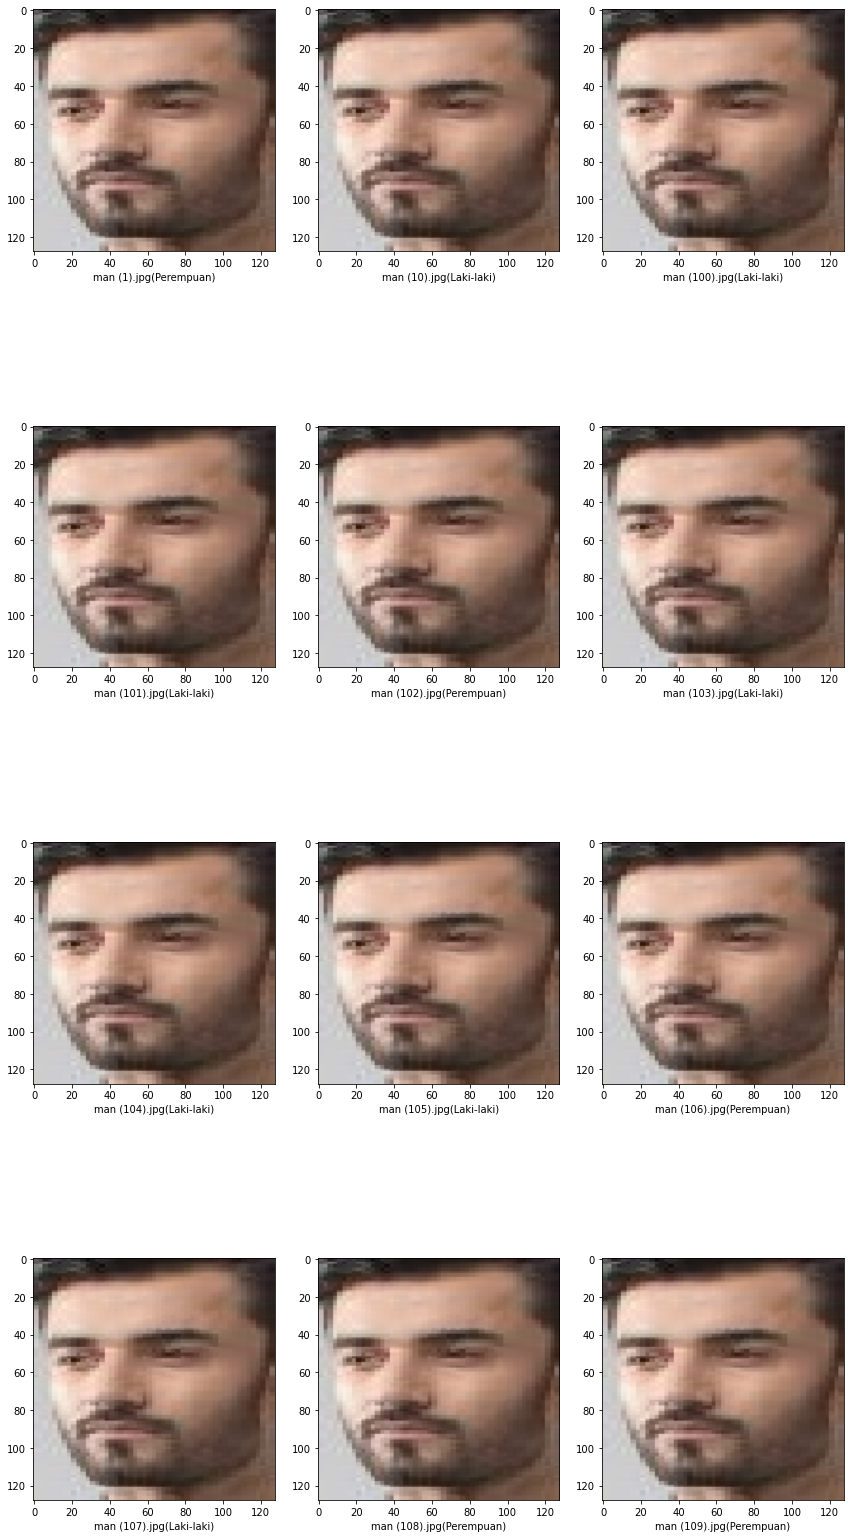

In [34]:
# Prediction

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['gender'] = test_df['gender'].replace(label_map)

test_df['gender'] = test_df['gender'].replace({ 'man': 1, 'woman': 0 })

sample_test = test_df.head(12)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['gender']
    img = load_img('../valid/man (25).jpg', target_size=IMAGE_SIZE)
    plt.subplot(4, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()